# Tutorial: Calculation of Localization Factor

In this tutorial, we will use WEST to determine the localization factor $\mathrm{L_V}$ of Kohn-Sham states. The localization factor is defined as
$$
L_V\left[ \psi^{KS}_n \right] = \int_{V \in \Omega} d^3r \left| \psi^{KS}_n(\mathbf{r}) \right|^2,
$$
and describes the localization of a wavefunction in a given volume $V$ within the supercell volume $\Omega$. Commonly, the localization factor is used to identify localized defect orbitals. More details can be found in <a href="https://doi.org/10.1021/acs.jctc.2c00240">Nan Sheng, Christian Vorwerk, Marco Govoni, and Giulia Galli, J. Chem. Theory Comput. 18, 6, 3512 (2022)</a>.

In this tutorial, we will use the localization factor to identify defect orbitals of the $\mathrm{NV^-}$ center in Diamond.

## Step 1: Mean-field Starting Point

As a first step, we have to perform the mean-field electronic structure calculations within density-functional theory (DFT) using the <a href='https://www.quantum-espresso.org/'>Quantum ESPRESSO</a> code.

Download the following files in your working directory:

In [ ]:
%%bash
wget -N -q http://www.west-code.org/doc/training/nv_diamond_63/pw.in
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/C_ONCV_PBE-1.0.upf
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/N_ONCV_PBE-1.0.upf

We can now inspect the `pw.in` file, the input for the `pw.x` code:

In [3]:
%%bash
cat pw.in

&CONTROL
calculation = 'scf'
wf_collect = .true.
pseudo_dir = './'
/
&SYSTEM
input_dft = 'PBE'
ibrav = 0
ecutwfc = 50
nosym = .true.
tot_charge = -1
nspin = 1
nbnd = 176
occupations = 'from_input'
nat = 63
ntyp = 2
/
&ELECTRONS
conv_thr = 1D-08
/
K_POINTS gamma
CELL_PARAMETERS angstrom
7.136012  0.000000  0.000000
0.000000  7.136012  0.000000
0.000000  0.000000  7.136012
ATOMIC_SPECIES
C  12.01099968  C_ONCV_PBE-1.0.upf
N  14.00699997  N_ONCV_PBE-1.0.upf
ATOMIC_POSITIONS crystal
C    0.99996000  0.99996000  0.99996000
C    0.12495000  0.12495000  0.12495000
C    0.99905000  0.25039000  0.25039000
C    0.12350000  0.37499000  0.37499000
C    0.25039000  0.99905000  0.25039000
C    0.37499000  0.12350000  0.37499000
C    0.25039000  0.25039000  0.99905000
C    0.37499000  0.37499000  0.12350000
C    0.00146000  0.00146000  0.50100000
C    0.12510000  0.12510000  0.62503000
C    0.00102000  0.24944000  0.74960000
C    0.12614000  0.37542000  0.87402000
C    0.24944000  0.00102000  0.74960

We can now run `pw.x` on 2 cores.

In [ ]:
%%bash
mpirun -n 2 pw.x -i pw.in > pw.out

## Step 2: Calculation of the Localization Factor

Localization factors are calculated with the `westpp.x` executable within WEST. You can download the input file with the following command:

In [4]:
%%bash 
wget -N -q http://www.west-code.org/doc/training/nv_diamond_63/westpp.in

Let us inspect the input file.

In [5]:
%%bash
cat westpp.in

wstat_control:                                                           
  wstat_calculation: S                                                   
  n_pdep_eigen: 512                                                       

westpp_control:                                            
  westpp_calculation: L                                                 
  westpp_range: [1, 176]
  westpp_box: [6.19, 10.19, 6.28, 10.28, 6.28, 10.28]                           


The keyword `westpp_calculation: L` triggers the calculation of the localization factor. With `westpp_range`, we can select for which Kohn-Sham states we determine the localization factor. In this tutorial, we use all 176 bands. Finally, `westpp_box` determines the parameter of a box in atomic coordinates to use for the integration. In this case, we have choosen a box around the carbon vacancy at $\left( 8.18, 8.28, 8.28 \right)^T$ Bohr. The box has a volume of 64 Bohr$^3$, much smaller than the supercell volume of 2452.24 Bohr$^3$.

In [ ]:
%%bash
mpirun -n 2 westpp.x -i westpp.in > westpp.out

Running `westpp.x` creates a directory named `west.westpp.save/localization.json`. If you don't have the computational ressources to run WEST, you can download the file using

In [8]:
%%bash
mkdir west.westpp.save
wget -N -q http://www.west-code.org/doc/training/nv_diamond_63/localization.json -O west.westpp.save/localization.json

We can now visualize the results:

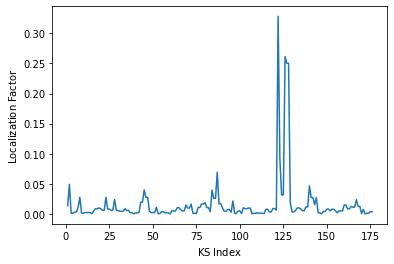

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open('west.westpp.save/localization.json', 'r') as f:
    localization = np.array(json.load(f)['localization'])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel(r'$\mathrm{KS \; Index}$')
ax1.set_ylabel(r'$\mathrm{Localization \; Factor}$')

ax1.plot([i+1 for i in range(localization.shape[0])], localization)

plt.show()

We see that a number of Kohn-Sham orbitals have a high localization factor. The highest localization factor is found for the Kohn-Sham orbitals with the index 122, 123, 126, 127, and 128. Additionally, the orbital 87 has considerable localization.